<a href="https://colab.research.google.com/github/sangjun315/FedAvg-Pytorch/blob/main/oneshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ MNIST 전체: (70000, 784), 클래스: 10
총 디바이스 수: 200
전역 테스트셋: (33476, 784)
✅ 로컬 모델 학습 완료: 200
✅ Figure 1 저장: outputs/figure1.png
✅ Figure 2 저장: outputs/figure2.png
✅ Figure 3 저장: outputs/figure3.png
🎉 완료! outputs/figure1.png, figure2.png, figure3.png 확인하세요.


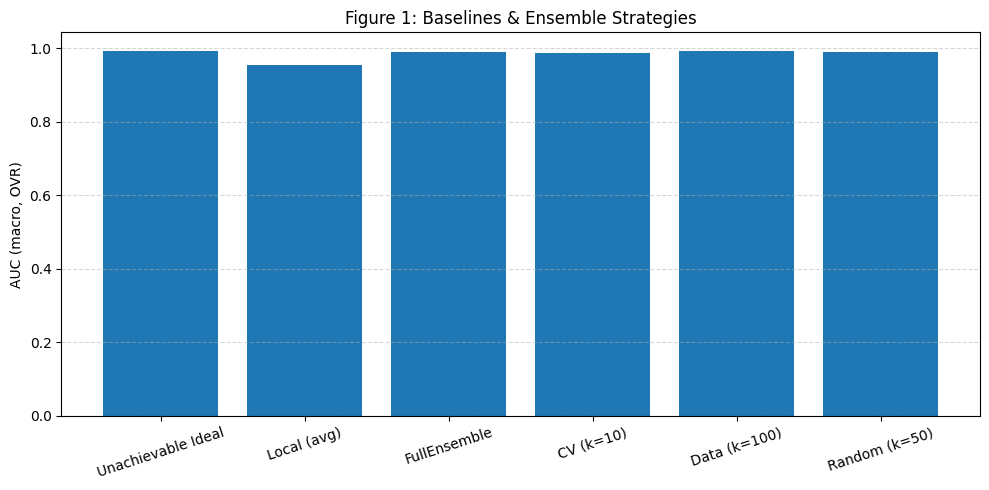

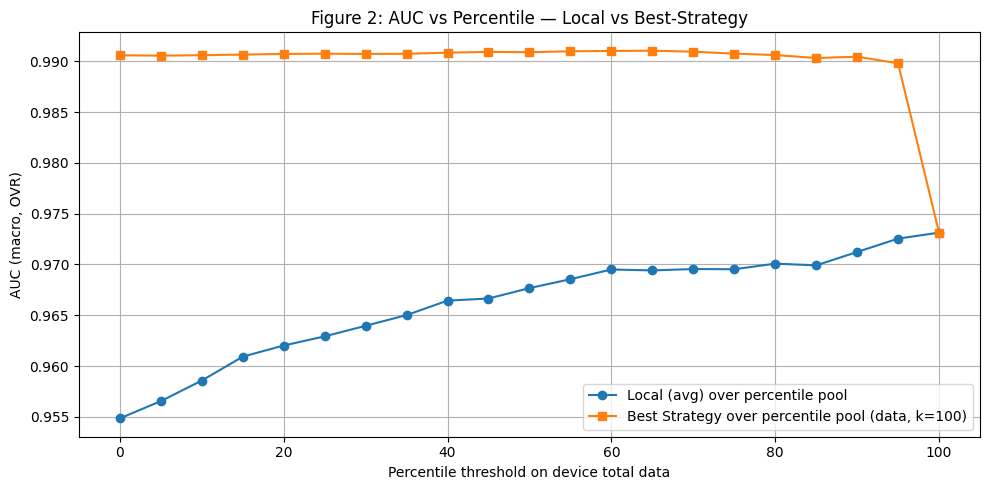

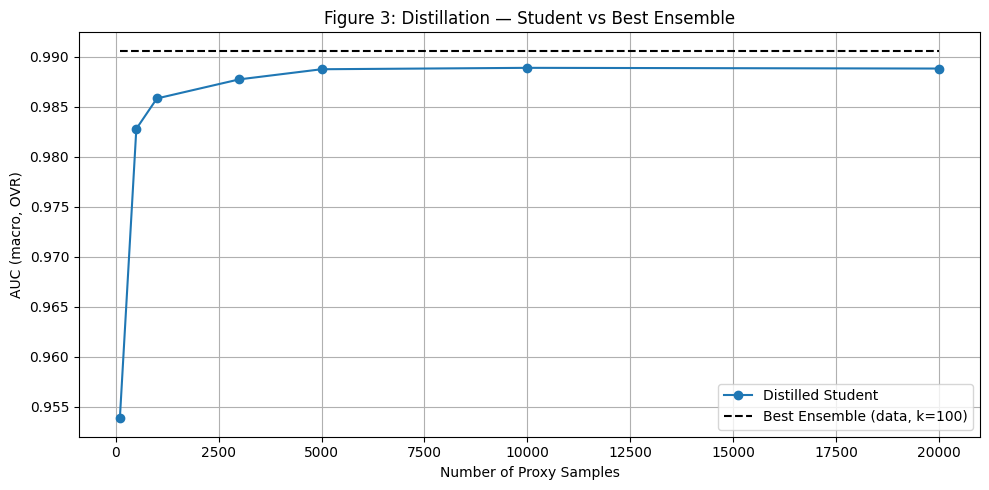

In [ ]:
# one_shot_fed_mnist_final_50_40_10.py
# One-Shot Federated Learning (논문 설정 반영 최종본)
# - MNIST만 사용(자동 다운로드)
# - num_devices=200
# - 각 디바이스 50/40/10 split (train/test/val)
# - Figure 1: [Ideal, Local(avg), FullEnsemble, CV(k=10), Data(k=100), Random(k=50)]
# - Figure 2: x=percentile, y=AUC  (Local curve vs Best-Strategy curve; 둘 다 퍼센타일 풀 기준)
# - Figure 3: x=Number of Proxy Samples, y=AUC (Best Ensemble = 수평선, Distilled Student = 곡선)

import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

# ====== 공통 설정 ======
RND = 123
np.random.seed(RND)
random.seed(RND)
os.makedirs("outputs", exist_ok=True)

# ====== MNIST 로드(항상 다운로드) ======
from tensorflow.keras.datasets import mnist

def load_mnist_strict():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x = np.vstack([x_train, x_test])
    y = np.hstack([y_train, y_test])
    x = x.reshape((x.shape[0], -1)).astype(np.float32) / 255.0
    print(f"✅ MNIST 전체: {x.shape}, 클래스: {len(np.unique(y))}")
    return x, y

X_all, y_all = load_mnist_strict()
num_classes = len(np.unique(y_all))

# ====== 도우미: AUC ======
def multiclass_auc(y_true, probs):
    lb = LabelBinarizer()
    lb.fit(range(num_classes))
    Yb = lb.transform(y_true)
    try:
        return roc_auc_score(Yb, probs, average='macro', multi_class='ovr')
    except:
        # degenerate case 안전 처리
        scores = []
        for c in range(num_classes):
            yt = (y_true == c).astype(int)
            if len(np.unique(yt)) < 2:
                continue
            scores.append(roc_auc_score(yt, probs[:, c]))
        return np.mean(scores) if scores else 0.5

# ====== 디바이스로 분할 + 각 디바이스 내부 50/40/10 split ======
def partition_devices_with_splits(X, y, num_devices=200, min_total=80, max_total=400, noniid=True):
    """각 디바이스에 total 샘플수를 먼저 랜덤 배정한 뒤, 그 묶음 안에서 50/40/10으로 split."""
    N = X.shape[0]
    Xs, ys = shuffle(X, y, random_state=RND)
    # 각 디바이스 total 크기 배정
    totals = np.random.randint(min_total, max_total + 1, size=num_devices)
    totals = (totals / totals.sum() * N).astype(int)
    totals = np.maximum(totals, 30)  # 너무 작은 디바이스 방지
    # 실제 슬라이스
    devices = []
    idx = 0
    for d in range(num_devices):
        t = totals[d]
        if idx + t > N:
            t = N - idx
        Xi = Xs[idx: idx + t]
        yi = ys[idx: idx + t]
        idx += t

        # Non-IID: 클래스 2개 선호 편향 조금 주입
        if noniid and len(yi) > 0:
            preferred = np.random.choice(num_classes, size=2, replace=False)
            mask = np.isin(yi, preferred)
            # 부족하면 선호 클래스 샘플을 전역에서 리샘플링(간단한 편향 주입)
            if mask.sum() < int(0.6 * len(yi)):
                pool_idx = np.where(np.isin(y, preferred))[0]
                if len(pool_idx) > 0:
                    add = max(1, int(0.2 * len(yi)))
                    chosen = np.random.choice(pool_idx, size=add, replace=True)
                    Xi = np.vstack([Xi, X[chosen]])
                    yi = np.hstack([yi, y[chosen]])

        # 50/40/10 split: 먼저 train(50%) vs 나머지(50%), 그 나머지를 test(40%) vs val(10%)
        if len(yi) < 10:
            # 지나치게 작은 경우 최소 슬라이스 보정
            devices.append({
                "train": (Xi, yi),
                "test":  (Xi, yi),
                "val":   (Xi, yi),
                "total": len(yi)
            })
            continue

        X_train, X_rest, y_train, y_rest = train_test_split(
            Xi, yi, test_size=0.5, random_state=RND, stratify=yi if len(np.unique(yi)) > 1 else None
        )
        # X_rest는 total의 50% → 여기서 test:val = 4:1 로 나누면 전체 비율 40/10이 됨
        if len(y_rest) >= 5 and len(np.unique(y_rest)) > 1:
            X_test, X_val, y_test_d, y_val = train_test_split(
                X_rest, y_rest, test_size=0.2, random_state=RND, stratify=y_rest
            )
        else:
            # stratify 불가 시 단순 split
            split = max(1, int(0.8 * len(X_rest)))
            X_test, X_val = X_rest[:split], X_rest[split:]
            y_test_d, y_val = y_rest[:split], y_rest[split:]

        devices.append({
            "train": (X_train, y_train),
            "test":  (X_test,  y_test_d),
            "val":   (X_val,   y_val),
            "total": len(yi)
        })

        if idx >= N:
            break

    # 모자라면 채우기
    while len(devices) < num_devices:
        devices.append({
            "train": (Xs[:min_total//2], ys[:min_total//2]),
            "test":  (Xs[:min_total//2], ys[:min_total//2]),
            "val":   (Xs[:min_total//10], ys[:min_total//10]),
            "total": min_total
        })
    return devices

devices = partition_devices_with_splits(X_all, y_all, num_devices=200)
n_models = len(devices)
print("총 디바이스 수:", n_models)

# 전역 테스트셋: 모든 디바이스의 test(40%)를 합침
X_test_global = np.vstack([dev["test"][0] for dev in devices if len(dev["test"][1]) > 0])
y_test_global = np.hstack([dev["test"][1] for dev in devices if len(dev["test"][1]) > 0])
print("전역 테스트셋:", X_test_global.shape)

# ====== 로컬 모델 ======
def train_local_model(X, y):
    # 논문 기준(EMNIST < 60) 참조해 임계 60 유지 (MNIST지만 동일 규칙)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    if len(y) < 60:
        maj = np.bincount(y).argmax()
        return {"kind": "constant", "maj": int(maj), "scaler": scaler}
    clf = LogisticRegression(max_iter=200, solver='saga', multi_class='multinomial', n_jobs=1)
    clf.fit(Xs, y)
    return {"kind": "skl", "model": clf, "scaler": scaler}

def predict_proba_model(modelobj, X):
    scaler = modelobj["scaler"]
    Xs = scaler.transform(X)
    if modelobj["kind"] == "constant":
        maj = modelobj["maj"]
        probs = np.zeros((X.shape[0], num_classes))
        probs[:, maj] = 1.0
        return probs
    return modelobj["model"].predict_proba(Xs)

def ensemble_predict_proba(indices, local_models, X):
    if len(indices) == 0:
        return np.zeros((X.shape[0], num_classes))
    total = np.zeros((X.shape[0], num_classes))
    for i in indices:
        total += predict_proba_model(local_models[i], X)
    return total / len(indices)

# 디바이스별 로컬 모델 학습 (train 50%만 사용)
local_models = []
for i, dev in enumerate(devices):
    Xi_tr, yi_tr = dev["train"]
    m = train_local_model(Xi_tr, yi_tr)
    local_models.append(m)
print("✅ 로컬 모델 학습 완료:", len(local_models))

# ====== Ideal (Unachievable) — 중앙 모델 ======
# 중앙 모델: 모든 디바이스의 train(50%) 를 합쳐 학습, 전역 test(40% 합)에서 평가
X_train_central = np.vstack([dev["train"][0] for dev in devices if len(dev["train"][1]) > 0])
y_train_central = np.hstack([dev["train"][1] for dev in devices if len(dev["train"][1]) > 0])

scaler_global = StandardScaler().fit(X_train_central)
central_clf = LogisticRegression(max_iter=400, solver='saga', multi_class='multinomial', n_jobs=1)
central_clf.fit(scaler_global.transform(X_train_central), y_train_central)
auc_ideal = multiclass_auc(y_test_global, central_clf.predict_proba(scaler_global.transform(X_test_global)))

# ====== Local (avg) ======
# 각 디바이스 로컬 모델을 "자기 디바이스의 test(40%)"에서 평가한 AUC의 평균
local_aucs = []
for i, dev in enumerate(devices):
    Xi_te, yi_te = dev["test"]
    if len(yi_te) == 0:
        continue
    probs = predict_proba_model(local_models[i], Xi_te)
    local_aucs.append(multiclass_auc(yi_te, probs))
auc_local_avg = float(np.mean(local_aucs)) if local_aucs else np.nan

# ====== 선택 전략 ======
def select_by_cv(devices, local_models, k):
    # 각 디바이스: train으로 학습된 local_models[i]의 "val(10%)" 성능을 계산하여 상위 k 선택
    scores = []
    for i, dev in enumerate(devices):
        Xi_val, yi_val = dev["val"]
        if len(yi_val) < 2 or len(np.unique(yi_val)) < 2:
            scores.append((i, 0.0)); continue
        probs_val = predict_proba_model(local_models[i], Xi_val)
        score = multiclass_auc(yi_val, probs_val)
        scores.append((i, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    return [idx for idx, _ in scores[:k]]

def select_by_data_amount(devices, k):
    # total(= 디바이스 총 샘플 수) 내림차순
    sizes = [(i, dev["total"]) for i, dev in enumerate(devices)]
    sizes.sort(key=lambda x: x[1], reverse=True)
    return [i for i, _ in sizes[:k]]

def select_random(devices, k):
    return random.sample(range(len(devices)), k)









✅ Figure 1 저장: outputs/figure1.png


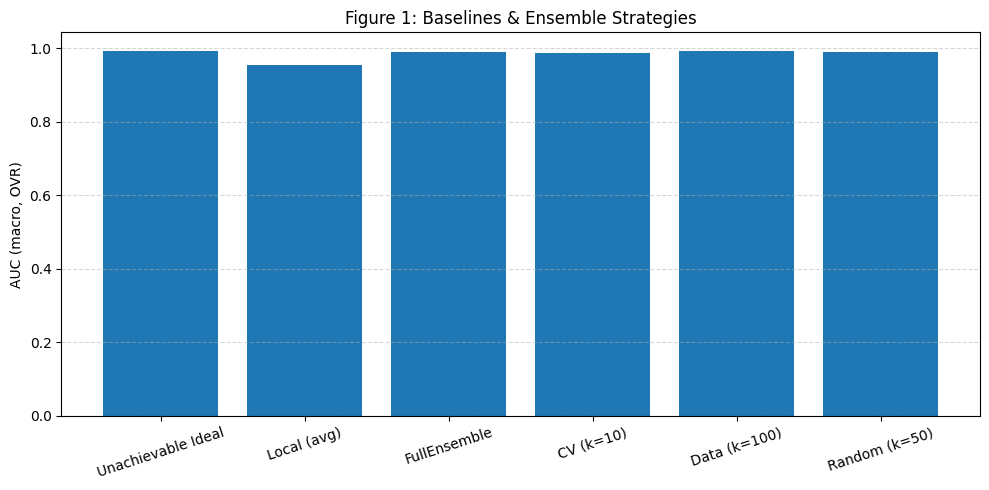

In [4]:
# ====== Figure 1 ======
k_cv, k_data, k_rand = 10, 100, 50  # 확정
sel_cv   = select_by_cv(devices, local_models, min(k_cv, n_models))
sel_data = select_by_data_amount(devices, min(k_data, n_models))
sel_rand = select_random(devices, min(k_rand, n_models))
sel_full = list(range(n_models))

auc_full   = multiclass_auc(y_test_global, ensemble_predict_proba(sel_full, local_models, X_test_global))
auc_cv     = multiclass_auc(y_test_global, ensemble_predict_proba(sel_cv,   local_models, X_test_global))
auc_data   = multiclass_auc(y_test_global, ensemble_predict_proba(sel_data, local_models, X_test_global))
auc_rand   = multiclass_auc(y_test_global, ensemble_predict_proba(sel_rand, local_models, X_test_global))

labels_f1 = [
    "Unachievable Ideal",
    "Local (avg)",
    "FullEnsemble",
    f"CV (k={k_cv})",
    f"Data (k={k_data})",
    f"Random (k={k_rand})"
]
scores_f1 = [auc_ideal, auc_local_avg, auc_full, auc_cv, auc_data, auc_rand]

plt.figure(figsize=(10,5))
plt.bar(labels_f1, scores_f1)
plt.ylabel("AUC (macro, OVR)")
plt.title("Figure 1: Baselines & Ensemble Strategies")
plt.xticks(rotation=18)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("outputs/figure1.png", dpi=150)
print("✅ Figure 1 저장: outputs/figure1.png")

✅ Figure 2 저장: outputs/figure2.png


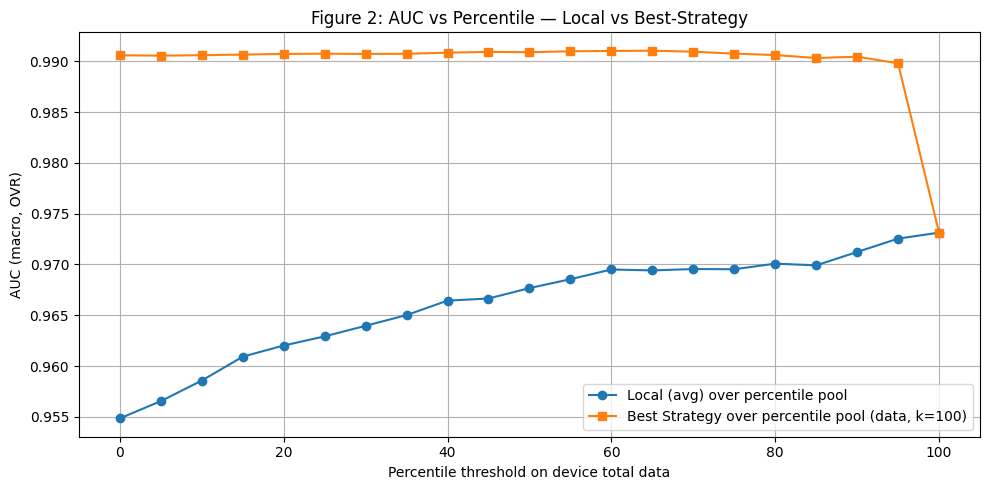

In [5]:
# ====== Figure 2 (x=percentile, y=AUC) ======
# 퍼센타일 기준: 디바이스 total 크기 분포 사용
totals = np.array([dev["total"] for dev in devices])
percentiles = list(range(0, 101, 5))

# Local curve: 퍼센타일 임계 이상 디바이스들의 "로컬 AUC(자기 test)" 평균
local_curve = []
# Best 전략 식별 (Figure 1에서 제일 높은 AUC)
strategy_scores = {"cv": auc_cv, "data": auc_data, "random": auc_rand}
best_strategy_name = max(strategy_scores, key=strategy_scores.get)
best_k = {"cv": k_cv, "data": k_data, "random": k_rand}[best_strategy_name]

def pick_by_strategy_with_pool(pool_indices, strategy_name, k):
    if len(pool_indices) == 0:
        return []
    k_eff = min(k, len(pool_indices))
    if strategy_name == "cv":
        scores = []
        for i in pool_indices:
            Xi_val, yi_val = devices[i]["val"]
            if len(yi_val) < 2 or len(np.unique(yi_val)) < 2:
                scores.append((i, 0.0)); continue
            probs_val = predict_proba_model(local_models[i], Xi_val)
            scores.append((i, multiclass_auc(yi_val, probs_val)))
        scores.sort(key=lambda x: x[1], reverse=True)
        return [idx for idx, _ in scores[:k_eff]]
    elif strategy_name == "data":
        pool_sizes = [(i, devices[i]["total"]) for i in pool_indices]
        pool_sizes.sort(key=lambda x: x[1], reverse=True)
        return [i for i, _ in pool_sizes[:k_eff]]
    elif strategy_name == "random":
        rng = np.random.RandomState(RND)
        return list(rng.choice(pool_indices, size=k_eff, replace=False))
    else:
        return list(pool_indices)

best_curve = []

for p in percentiles:
    thresh = np.percentile(totals, p)
    pool = [i for i, t in enumerate(totals) if t >= thresh]

    # Local curve at percentile p: 풀 내 디바이스들의 로컬 AUC 평균(각자 test에서)
    local_vals = []
    for i in pool:
        Xi_te, yi_te = devices[i]["test"]
        if len(yi_te) == 0:
            continue
        probs = predict_proba_model(local_models[i], Xi_te)
        local_vals.append(multiclass_auc(yi_te, probs))
    local_curve.append(np.mean(local_vals) if local_vals else np.nan)

    # Best-strategy curve at percentile p: 풀 내에서 best 전략으로 k개 선택 → 풀의 test(모두 합친 것)에서 앙상블 AUC
    chosen = pick_by_strategy_with_pool(pool, best_strategy_name, best_k)
    if len(chosen) == 0:
        best_curve.append(np.nan)
    else:
        X_pool_test = np.vstack([devices[i]["test"][0] for i in pool if len(devices[i]["test"][1]) > 0])
        y_pool_test = np.hstack([devices[i]["test"][1] for i in pool if len(devices[i]["test"][1]) > 0])
        probs_ens = ensemble_predict_proba(chosen, local_models, X_pool_test)
        best_curve.append(multiclass_auc(y_pool_test, probs_ens))

plt.figure(figsize=(10,5))
plt.plot(percentiles, local_curve, marker='o', label='Local (avg) over percentile pool')
plt.plot(percentiles, best_curve, marker='s', label=f'Best Strategy over percentile pool ({best_strategy_name}, k={best_k})')
plt.xlabel("Percentile threshold on device total data")
plt.ylabel("AUC (macro, OVR)")
plt.title("Figure 2: AUC vs Percentile — Local vs Best-Strategy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/figure2.png", dpi=150)
print("✅ Figure 2 저장: outputs/figure2.png")

✅ Figure 3 저장: outputs/figure3.png
🎉 완료! outputs/figure1.png, figure2.png, figure3.png 확인하세요.


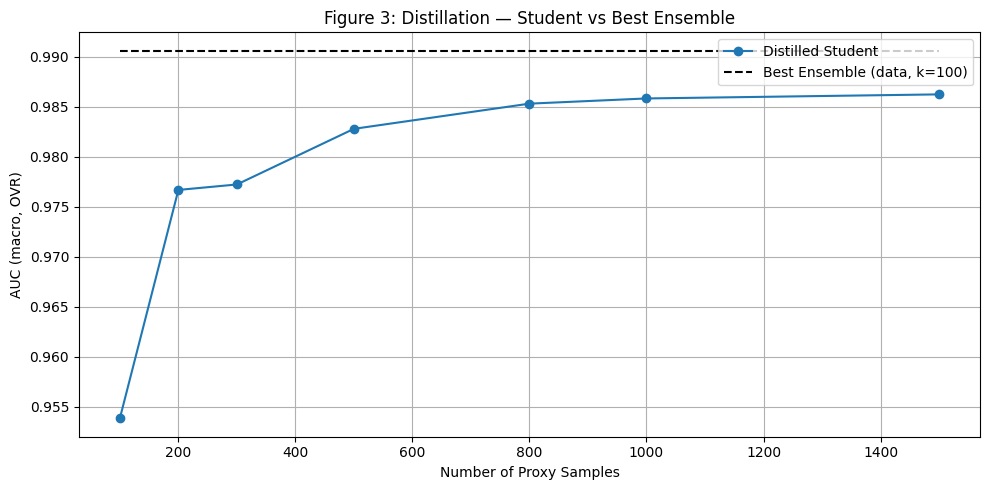

In [6]:
# ====== Figure 3 (x=Number of Proxy Samples, y=AUC) ======
# Best 전략을 교사로 사용, 프록시 샘플 수를 늘려가며 학생 모델 증류
best_sel = {
    "cv": sel_cv, "data": sel_data, "random": sel_rand
}[best_strategy_name]

# 교사 앙상블의 전역 테스트 AUC (수평선)
auc_best_teacher = multiclass_auc(y_test_global, ensemble_predict_proba(best_sel, local_models, X_test_global))

# 프록시 샘플은 "디바이스들의 train(50%)" 전체에서 무작위 추출 (라벨 불필요)
X_train_union = np.vstack([dev["train"][0] for dev in devices if len(dev["train"][1]) > 0])
# 논문처럼 초반(<= 5k) 구간을 촘촘히, 상한은 5k로 컷
proxy_sizes = [100, 200, 300, 500, 800, 1000, 1500]
proxy_sizes = [n for n in proxy_sizes if n <= len(X_train_union)]


student_aucs = []
for n in proxy_sizes:
    # 프록시 입력 추출
    rng = np.random.RandomState(RND + n)  # 각 n마다 고정 시드
    idxs = rng.choice(len(X_train_union), size=n, replace=False)
    X_proxy = X_train_union[idxs]

    # 교사 소프트 라벨 (여기서는 간소화: argmax로 pseudo-label)
    teacher_probs = ensemble_predict_proba(best_sel, local_models, X_proxy)
    y_pseudo = np.argmax(teacher_probs, axis=1)

    # 학생 모델 학습 (간단 MLP)
    student = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=RND)
    student.fit(X_proxy, y_pseudo)

    # 전역 테스트셋에서 학생 모델 AUC
    try:
        p_student = student.predict_proba(X_test_global)
    except:
        preds = student.predict(X_test_global)
        p_student = np.zeros((len(preds), num_classes))
        p_student[np.arange(len(preds)), preds] = 1.0
    student_aucs.append(multiclass_auc(y_test_global, p_student))

plt.figure(figsize=(10,5))
plt.plot(proxy_sizes, student_aucs, marker='o', label='Distilled Student')
plt.hlines(auc_best_teacher, xmin=proxy_sizes[0], xmax=proxy_sizes[-1],
           colors='k', linestyles='--', label=f'Best Ensemble ({best_strategy_name}, k={best_k})')
plt.xlabel("Number of Proxy Samples")
plt.ylabel("AUC (macro, OVR)")
plt.title("Figure 3: Distillation — Student vs Best Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/figure3.png", dpi=150)
print("✅ Figure 3 저장: outputs/figure3.png")

print("🎉 완료! outputs/figure1.png, figure2.png, figure3.png 확인하세요.")